# Interactions

In [2]:
import igraph as ig
from gprofiler import GProfiler
import leidenalg as la
import pandas as pd
import matplotlib.pyplot as plt
import random
import matplotlib.pyplot as plt
import networkx as nx
from netgraph import Graph
import seaborn as sns




d_1=pd.read_csv('d_1_xgb.csv',header=None)
d_1.columns=["ensembl_gene_id"]
prot_conv=pd.read_csv('prot_converter.csv')

merge the prot_conv to the d_1 to get the protein ids

In [3]:
d_1_prot=pd.merge(d_1,prot_conv,left_on='ensembl_gene_id',right_on='ensb_gene_id',how='inner')
d_1_prot=d_1_prot[['ensembl_gene_id','ensb_prot_id','syb']]

ensb_prot_id_list=d_1_prot['ensb_prot_id'].tolist()
ensb_gene_id_list=d_1_prot['ensembl_gene_id'].tolist()


d_1_prot

,ensembl_gene_id,ensb_prot_id,syb
0,ENSG00000101040,ENSP00000420095,ZMYND8
1,ENSG00000177200,ENSP00000396345,CHD9
2,ENSG00000100888,ENSP00000495240,CHD8
3,ENSG00000116539,ENSP00000376204,ASH1L
4,ENSG00000118058,ENSP00000436786,KMT2A
...,...,...,...
1889,ENSG00000196313,ENSP00000405562,POM121
1890,ENSG00000181218,ENSP00000508783,H2AC25
1891,ENSG00000060709,ENSP00000509157,RIMBP2
1892,ENSG00000171824,ENSP00000366135,EXOSC10


In [35]:
d_1_prot.duplicated(subset=['ensb_prot_id']).sum()

0

In [36]:
unique=set(d_1_prot['ensb_prot_id'].tolist())
unique_df=pd.DataFrame(unique)
unique_df.to_csv('unique_proteins.csv',index=False,header=False)

# Read and Filter the String DB

In [37]:

# Load the dataset from the text file
data = pd.read_csv("9606.protein.links.v12.0.txt.gz", sep=" ",compression="gzip")

data.columns=["protein1","protein2","weight"]

data["protein1"]=data["protein1"].str.split('.').str[1]
data["protein2"]=data["protein2"].str.split('.').str[1]
data["weight"]=data["weight"]/1000
print(data.size)

#data=data[data["protein1"].isin(ensb_prot_id_list) & data["protein2"].isin(ensb_prot_id_list)]
print(data.size)


41146212
41146212


In [38]:
data=data[data["protein1"].isin(ensb_prot_id_list) & data["protein2"].isin(ensb_prot_id_list)]

In [39]:
d_1_prot= d_1_prot.set_index('ensb_prot_id')
data["protein1"]=data["protein1"].map(d_1_prot['ensembl_gene_id'])
data["protein2"]=data["protein2"].map(d_1_prot['ensembl_gene_id'])

In [41]:
data.isna().sum()

protein1    0
protein2    0
weight      0
dtype: int64

In [42]:
data.to_csv('data_filtered.csv',index=False)

In [6]:
data=pd.read_csv('data_filtered.csv')

# Make the graph

In [101]:
mygraph = ig.Graph.DataFrame(data, use_vids = False,directed=False)
partition = la.find_partition(mygraph, la.ModularityVertexPartition)

layout = mygraph.layout("fr") # Fruchterman-Reingold layout
partition_sizes = [len(partition) for partition in partition]
print(len(partition_sizes))
communities = partition


4


In [102]:
print(f'len membership {len(partition.membership)}')
print(f'how many vs {len(mygraph.vs)}')

len membership 1334
how many vs 1334


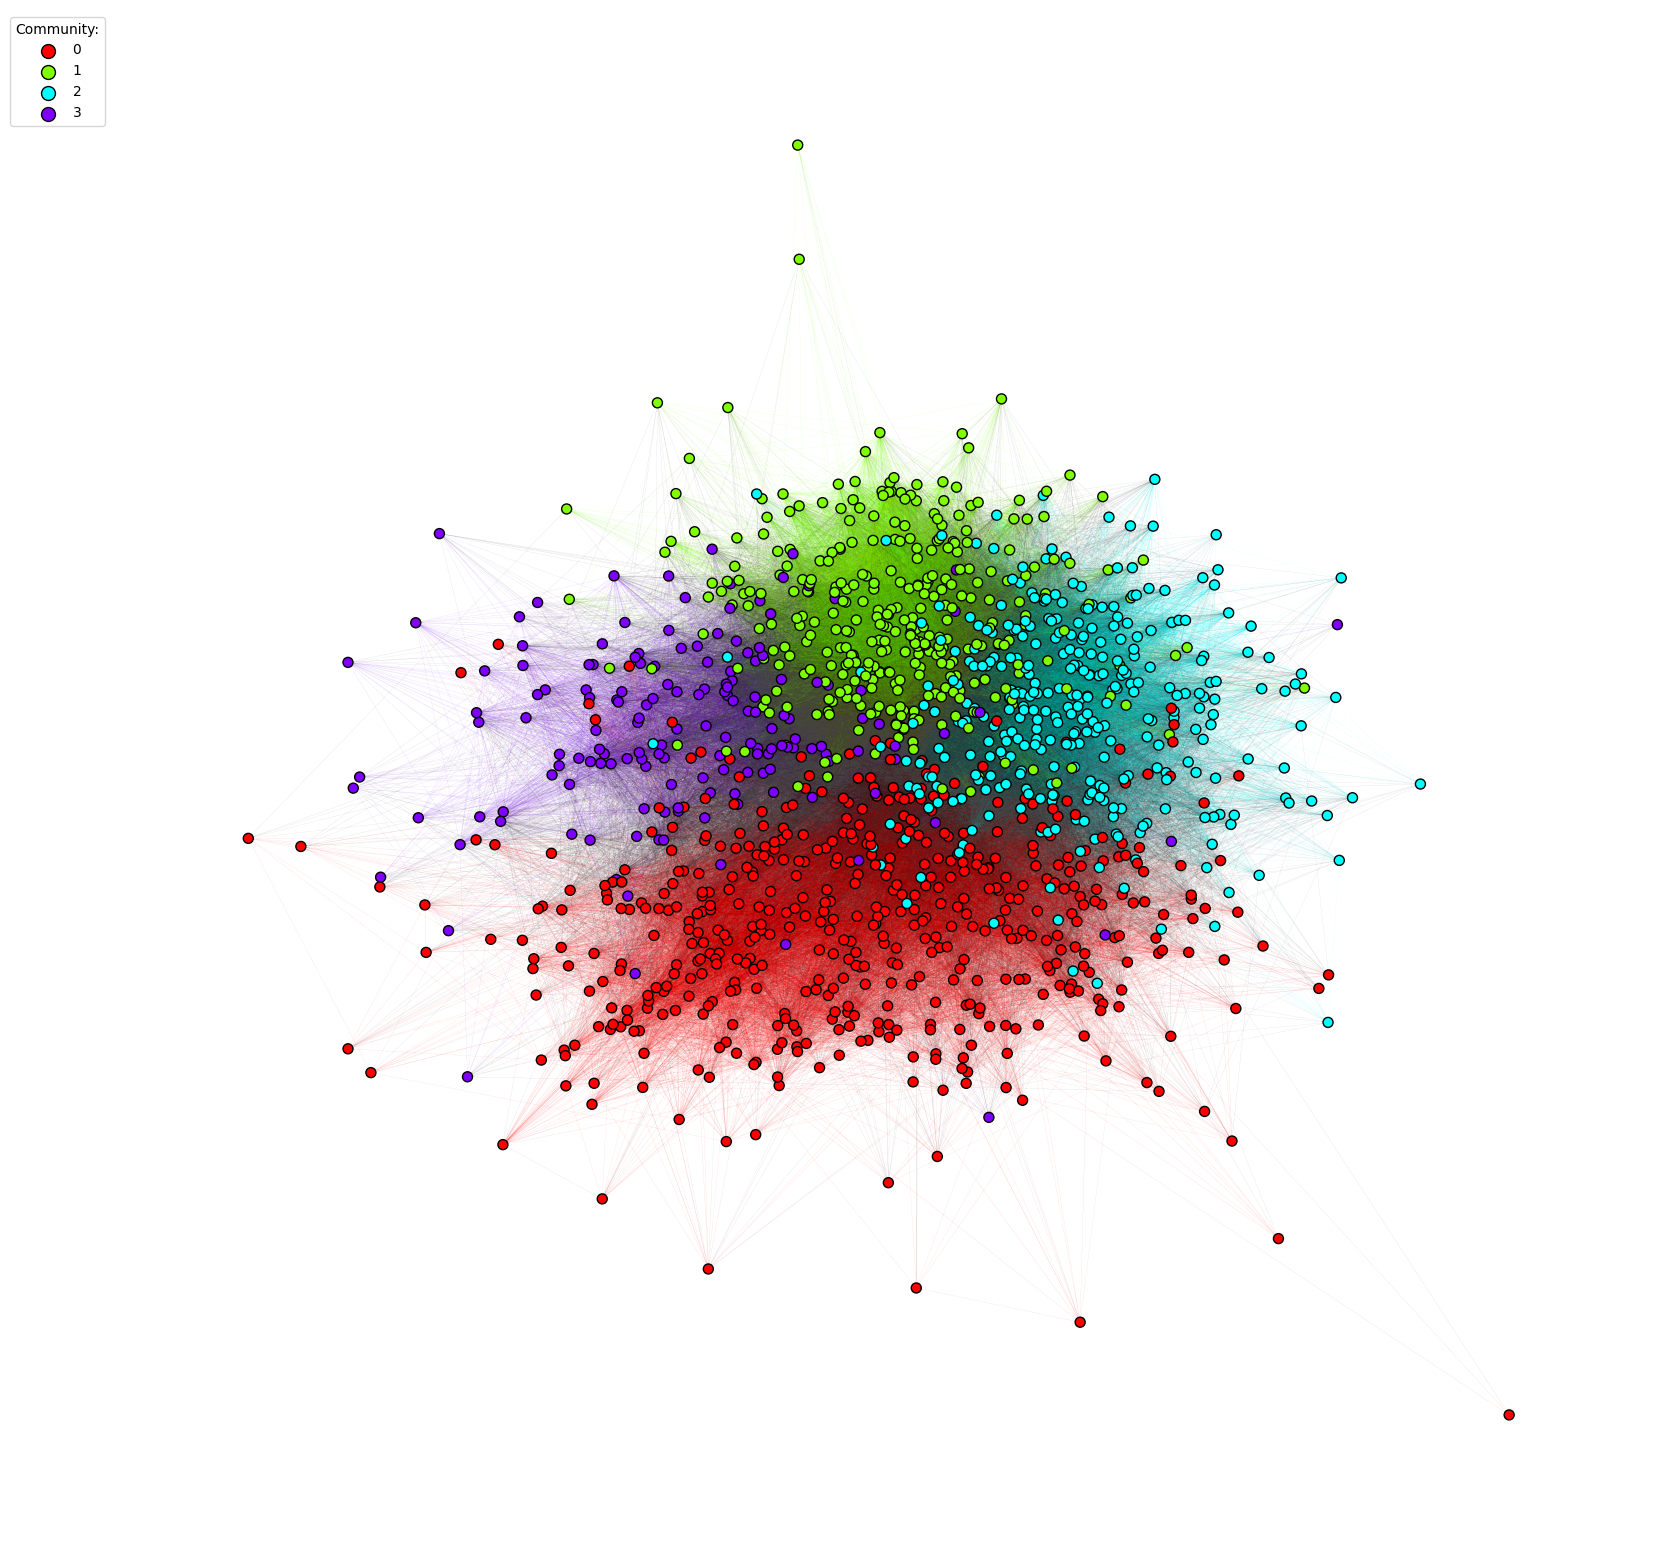

In [103]:
num_communities = len(communities)
palette = ig.RainbowPalette(n=num_communities)
for i, community in enumerate(communities):
    mygraph.vs[community]["color"] = i
    community_edges = mygraph.es.select(_within=community)
    community_edges["color"] = i

fig, ax = plt.subplots(figsize=(20, 20))
ig.plot(
    communities,
    palette=palette,
    edge_width=0.015,
    vertex_size=10,
    arrow_size=0,
    target="graph.png",
    
)

# Create a custom color legend
legend_handles = []
for i in range(num_communities):
    handle = ax.scatter(
        [], [],
        s=100,
        facecolor=palette.get(i),
        edgecolor="k",
        label=i,
    )
    legend_handles.append(handle)
ax.legend(
    handles=legend_handles,
    title='Community:',
    bbox_to_anchor=(0, 1.0),
    bbox_transform=ax.transAxes,
)

plt.show()

# 


# 


# 


# With netgraph 

In [10]:
mygraph = ig.Graph.DataFrame(data, use_vids = False,directed=False)
partition_la = la.find_partition(mygraph, la.ModularityVertexPartition)

partition_sizes = [len(partition) for partition in partition_la]
print(len(partition_sizes))

partition_list=[] 
for i in range(len(partition_sizes)):
    partition_list.append(set(partition_la[i]))

node_to_community_dict={}
for vertex,cluster_n in zip(mygraph.vs,partition_la.membership):
    node_to_community_dict[vertex["name"]]=cluster_n

edges = []
for prot1,prot2 in zip(data["protein1"].tolist(),data["protein2"].tolist()):
    edges.append((prot1,prot2))

num_communities = len(partition_la)

4


KeyboardInterrupt: 

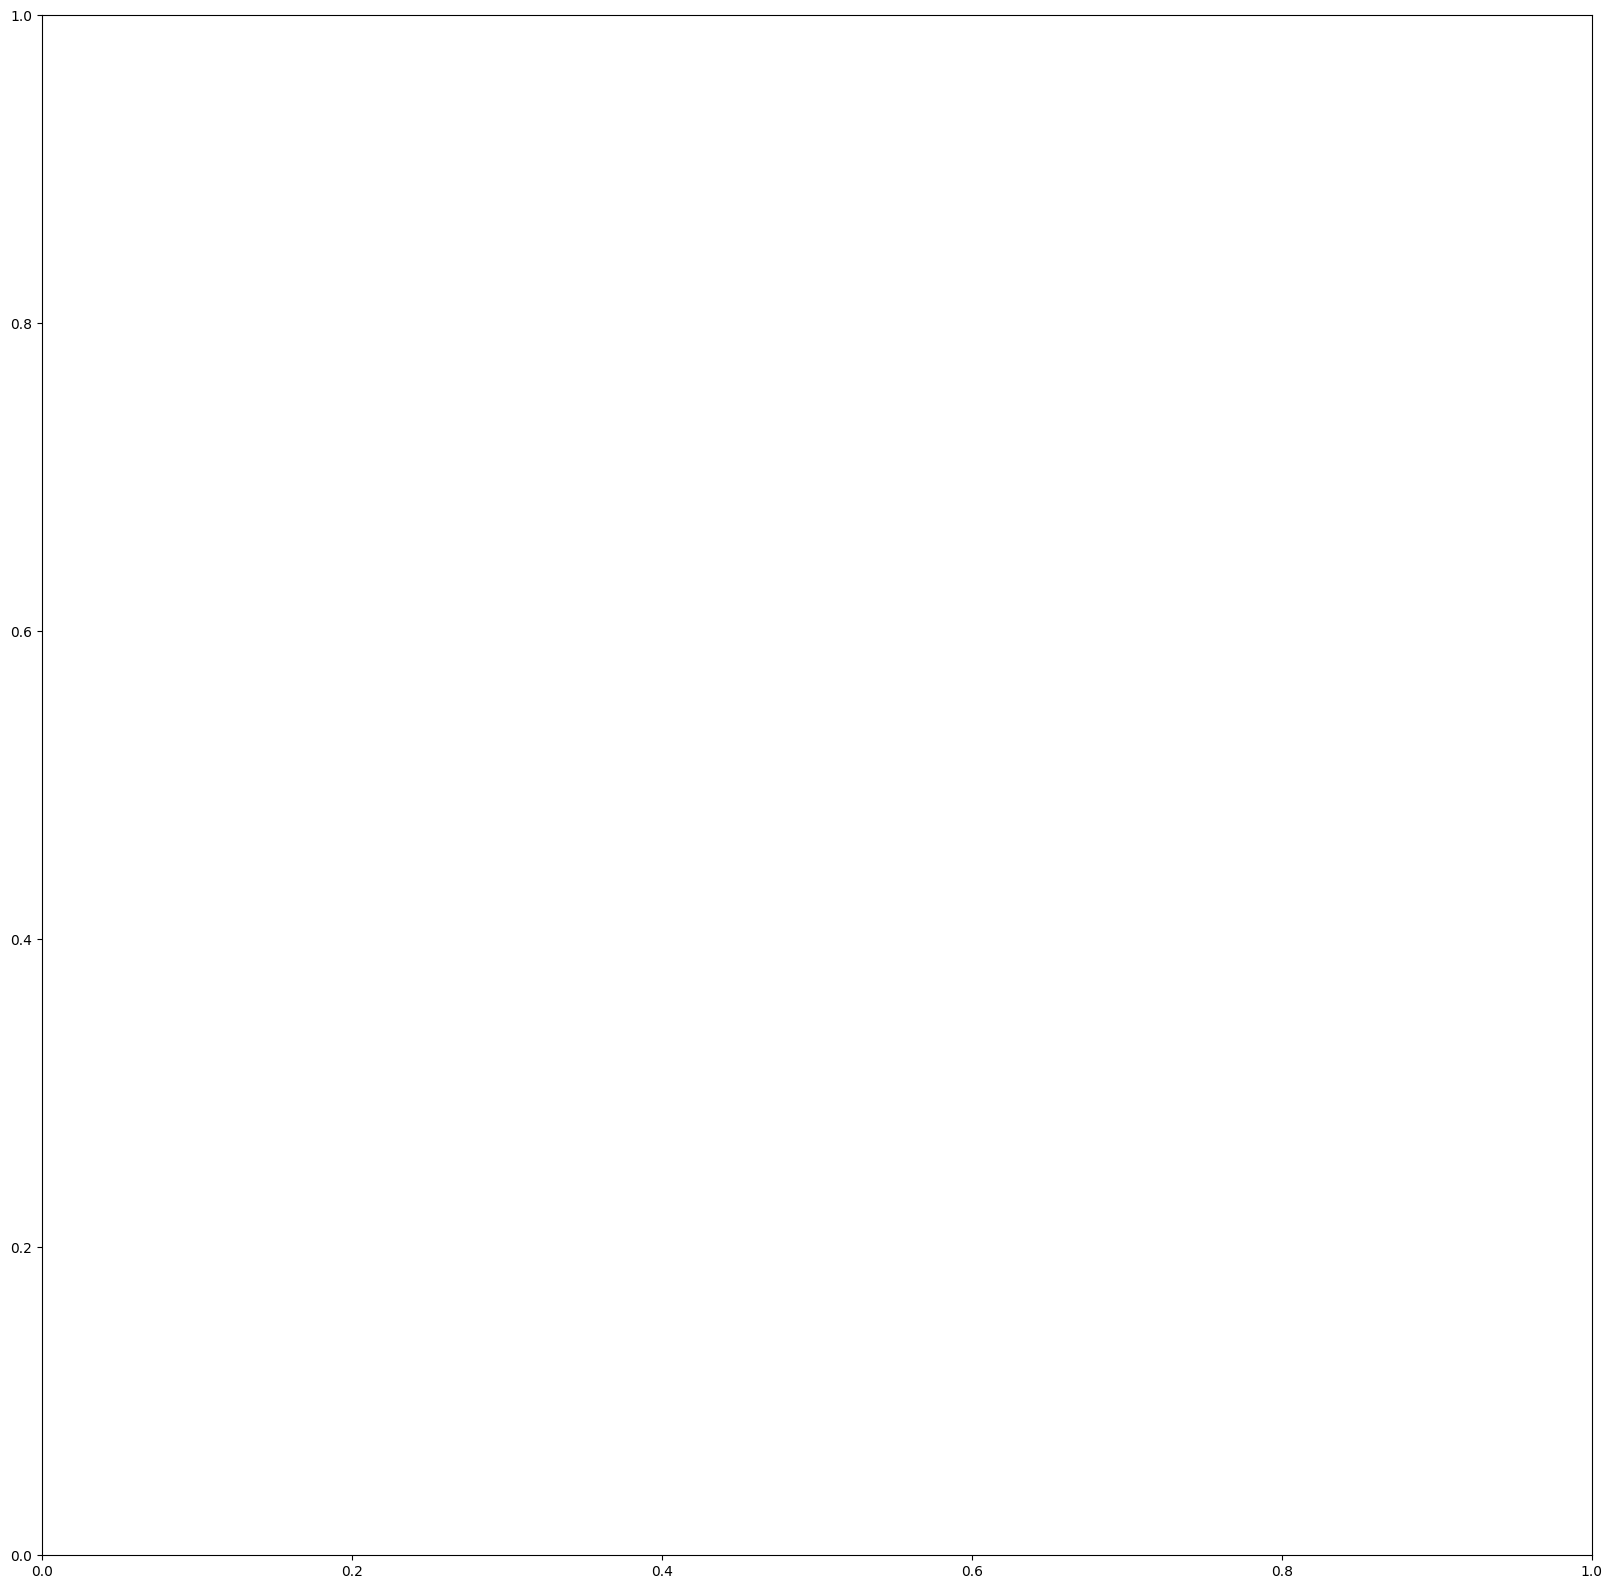

In [11]:


community_to_color = sns.color_palette("gist_ncar", num_communities).as_hex()

node_color = {node: community_to_color[node_to_community_dict[node]] for node in mygraph.vs["name"]}

fig, ax = plt.subplots(figsize=(20, 20))
Graph(edges,
      node_color=node_color, 
      node_edge_width=0.15,     
      edge_width=0.007,        
      edge_alpha=0.1,        
      node_layout='community', 
      node_layout_kwargs=dict(node_to_community=node_to_community_dict),
      ax=ax,
      node_size=0.6,
)

#      


plt.savefig('community_graph.png')

# Communities car

In [12]:
cluster_list=[]
for vertex,cluster_n in zip(mygraph.vs,partition_la.membership):
    cluster_list.append([vertex["name"],cluster_n])

cluster_df=pd.DataFrame(cluster_list,columns=["ensb_prot_id","cluster"])

n_clusters=cluster_df["cluster"].unique()
print(n_clusters)

cluster_dict={}
for cluster in n_clusters:
    cluster_dict[cluster]=cluster_df[cluster_df["cluster"]==cluster]["ensb_prot_id"].tolist()


[2 3 1 0]


In [20]:
df=pd.DataFrame(cluster_list,columns=["ensb_prot_id","cluster"])
df.to_csv('cluster.csv',index=False)

In [95]:
# export each cluster to a file
def export_com(com_dict):
    for key in com_dict.keys():
        com=com_dict[key]
        with open(f'communities/community_{key}.txt','w') as f:
            for item in com:
                f.write(f"{item}\n")

export_com(cluster_dict)

### Gprofile

In [96]:
def gprofiler(genes):
    gp = GProfiler(return_dataframe=True)
    gp_results = gp.profile(organism='hsapiens', query=genes)
    return gp_results

### Enrinch

In [97]:
cluster_results = {}
for cluster_id, genes in cluster_dict.items():
    cluster_results[cluster_id] = gprofiler(genes)
cluster_results = dict(sorted(cluster_results.items()))# order the results by cluster id



In [100]:
#term_filter=["GO:BP","GO:CC","KEGG","REAC"]
term_filter=["REAC"]
for cluster_id, cluster_data in cluster_results.items():

    print("-"*60 + f"Cluster {cluster_id}" + "-"*60)

    cluster_data = cluster_data[cluster_data["source"].isin(term_filter)]
    cluster_data=cluster_data[["source","native","name","p_value","description"]]
    cluster_data = cluster_data.sort_values(by=["source", "p_value"])

    cluster_data = cluster_data.groupby("source").head(10)

    cluster_data.reset_index(drop=True, inplace=True)

    
    display(cluster_data)


------------------------------------------------------------Cluster 0------------------------------------------------------------


,source,native,name,p_value,description
0,REAC,REAC:R-HSA-4839726,Chromatin organization,7.777682e-126,Chromatin organization
1,REAC,REAC:R-HSA-3247509,Chromatin modifying enzymes,7.777682e-126,Chromatin modifying enzymes
2,REAC,REAC:R-HSA-74160,Gene expression (Transcription),1.737229e-63,Gene expression (Transcription)
3,REAC,REAC:R-HSA-3214847,HATs acetylate histones,1.770558e-62,HATs acetylate histones
4,REAC,REAC:R-HSA-212165,Epigenetic regulation of gene expression,1.018830e-60,Epigenetic regulation of gene expression
5,REAC,REAC:R-HSA-3214815,HDACs deacetylate histones,1.477912e-55,HDACs deacetylate histones
6,REAC,REAC:R-HSA-73857,RNA Polymerase II Transcription,1.391785e-49,RNA Polymerase II Transcription
7,REAC,REAC:R-HSA-212436,Generic Transcription Pathway,4.361631e-49,Generic Transcription Pathway
8,REAC,REAC:R-HSA-8878171,Transcriptional regulation by RUNX1,8.776720e-49,Transcriptional regulation by RUNX1
9,REAC,REAC:R-HSA-9018519,Estrogen-dependent gene expression,2.461826e-47,Estrogen-dependent gene expression


------------------------------------------------------------Cluster 1------------------------------------------------------------


,source,native,name,p_value,description
0,REAC,REAC:R-HSA-199991,Membrane Trafficking,3.532265e-29,Membrane Trafficking
1,REAC,REAC:R-HSA-162582,Signal Transduction,1.973152e-27,Signal Transduction
2,REAC,REAC:R-HSA-9716542,"Signaling by Rho GTPases, Miro GTPases and RHO...",5.499471e-26,"Signaling by Rho GTPases, Miro GTPases and RHO..."
3,REAC,REAC:R-HSA-5653656,Vesicle-mediated transport,6.028200e-26,Vesicle-mediated transport
4,REAC,REAC:R-HSA-194315,Signaling by Rho GTPases,8.540475e-26,Signaling by Rho GTPases
5,REAC,REAC:R-HSA-8873719,RAB geranylgeranylation,1.267373e-21,RAB geranylgeranylation
6,REAC,REAC:R-HSA-9012999,RHO GTPase cycle,1.393866e-20,RHO GTPase cycle
7,REAC,REAC:R-HSA-9007101,Rab regulation of trafficking,1.925277e-17,Rab regulation of trafficking
8,REAC,REAC:R-HSA-9013149,RAC1 GTPase cycle,4.564188e-17,RAC1 GTPase cycle
9,REAC,REAC:R-HSA-8854214,TBC/RABGAPs,1.099169e-12,TBC/RABGAPs


------------------------------------------------------------Cluster 2------------------------------------------------------------


,source,native,name,p_value,description
0,REAC,REAC:R-HSA-8953854,Metabolism of RNA,1.420593e-47,Metabolism of RNA
1,REAC,REAC:R-HSA-72203,Processing of Capped Intron-Containing Pre-mRNA,9.311159e-47,Processing of Capped Intron-Containing Pre-mRNA
2,REAC,REAC:R-HSA-72163,mRNA Splicing - Major Pathway,1.723527e-37,mRNA Splicing - Major Pathway
3,REAC,REAC:R-HSA-72172,mRNA Splicing,9.978277e-37,mRNA Splicing
4,REAC,REAC:R-HSA-983168,Antigen processing: Ubiquitination & Proteasom...,1.673391e-14,Antigen processing: Ubiquitination & Proteasom...
5,REAC,REAC:R-HSA-983169,Class I MHC mediated antigen processing & pres...,9.840919e-12,Class I MHC mediated antigen processing & pres...
6,REAC,REAC:R-HSA-72187,mRNA 3'-end processing,2.989155e-11,mRNA 3'-end processing
7,REAC,REAC:R-HSA-73856,RNA Polymerase II Transcription Termination,3.287108e-10,RNA Polymerase II Transcription Termination
8,REAC,REAC:R-HSA-72202,Transport of Mature Transcript to Cytoplasm,5.925900e-10,Transport of Mature Transcript to Cytoplasm
9,REAC,REAC:R-HSA-74160,Gene expression (Transcription),1.842278e-09,Gene expression (Transcription)


------------------------------------------------------------Cluster 3------------------------------------------------------------


,source,native,name,p_value,description
0,REAC,REAC:R-HSA-112316,Neuronal System,2.636364e-45,Neuronal System
1,REAC,REAC:R-HSA-112315,Transmission across Chemical Synapses,1.332447e-24,Transmission across Chemical Synapses
2,REAC,REAC:R-HSA-6794362,Protein-protein interactions at synapses,1.042942e-18,Protein-protein interactions at synapses
3,REAC,REAC:R-HSA-112314,Neurotransmitter receptors and postsynaptic si...,4.317627e-17,Neurotransmitter receptors and postsynaptic si...
4,REAC,REAC:R-HSA-6794361,Neurexins and neuroligins,4.486416e-13,Neurexins and neuroligins
5,REAC,REAC:R-HSA-422475,Axon guidance,7.902521e-10,Axon guidance
6,REAC,REAC:R-HSA-9675108,Nervous system development,2.384993e-09,Nervous system development
7,REAC,REAC:R-HSA-977443,GABA receptor activation,2.293841e-08,GABA receptor activation
8,REAC,REAC:R-HSA-438066,"Unblocking of NMDA receptors, glutamate bindin...",5.870062e-07,"Unblocking of NMDA receptors, glutamate bindin..."
9,REAC,REAC:R-HSA-212676,Dopamine Neurotransmitter Release Cycle,1.267354e-06,Dopamine Neurotransmitter Release Cycle
